# Load Data 

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils import np_utils

X_train = np.load('data/X_train.npy')
X_test = np.load('data/X_test.npy')
y_train = np.load('data/y_train.npy')
y_test = np.load('data/y_test.npy')
max_length = int(np.load('data/max.npy'))

In [22]:
if len(set(y_train)) == 2:
    num_classes = 2
    activation = 'sigmoid'
    loss = 'brinary_crossentropy'
    output = 1
else:
    num_classes = 10
    y_train = np_utils.to_categorical(y_train, num_classes)
    y_test = np_utils.to_categorical(y_test, num_classes)
    activation = 'softmax'
    loss = 'categorical_crossentropy'
    output = 10 


In [9]:
X_train.shape

(412, 1022, 3)

In [10]:
y_train.shape

(412,)

In [11]:
X_test.shape

(46, 1022, 3)

In [12]:
X_train.shape[1]

1022

In [13]:
import pywt
from scipy import signal

#rng = X_train.shape[1]
rng = 250
scales = range(1, rng + 1)
waveletname = 'morl'
dt = 0.0512  # 512 Hz sampling
widths = pywt.scale2frequency(waveletname, scales) / dt


def create_plots(sample, color):
    '''
    :param rows: rows from ranges of taget values 
    :param data: data frame to use
    :return: plot of sigals, cwt and target response 
    '''

    plt.figure(figsize=(35,5))

    plt.subplot(1,7,1)
    plt.plot(X_train[sample, :, 0])

    plt.subplot(1,7,2)
    cwtmatr, freq = pywt.cwt(X_train[sample, :, 0], scales, waveletname)
    plt.imshow(cwtmatr, extent=[-1, 1, 1, rng], cmap=color, aspect='auto',
           vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())

    plt.subplot(1,7,3)
    plt.plot(X_train[sample, :, 1])

    plt.subplot(1,7,4)
    cwtmatr, freq = pywt.cwt(X_train[sample, :, 1], scales, waveletname)
    plt.imshow(cwtmatr, extent=[-1, 1, 1, rng], cmap=color, aspect='auto',
           vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
    
    plt.subplot(1,7,5)
    plt.plot(X_train[sample, :, 2])

    plt.subplot(1,7,6)
    cwtmatr, freq = pywt.cwt(X_train[sample, :, 2], scales, waveletname)
    plt.imshow(cwtmatr, extent=[-1, 1, 1, rng], cmap=color, aspect='auto',
           vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
    
    
    plt.subplot(1,7,7)
    plt.text(0.35, 0.5, y_train[sample], dict(size=30))

    plt.show()

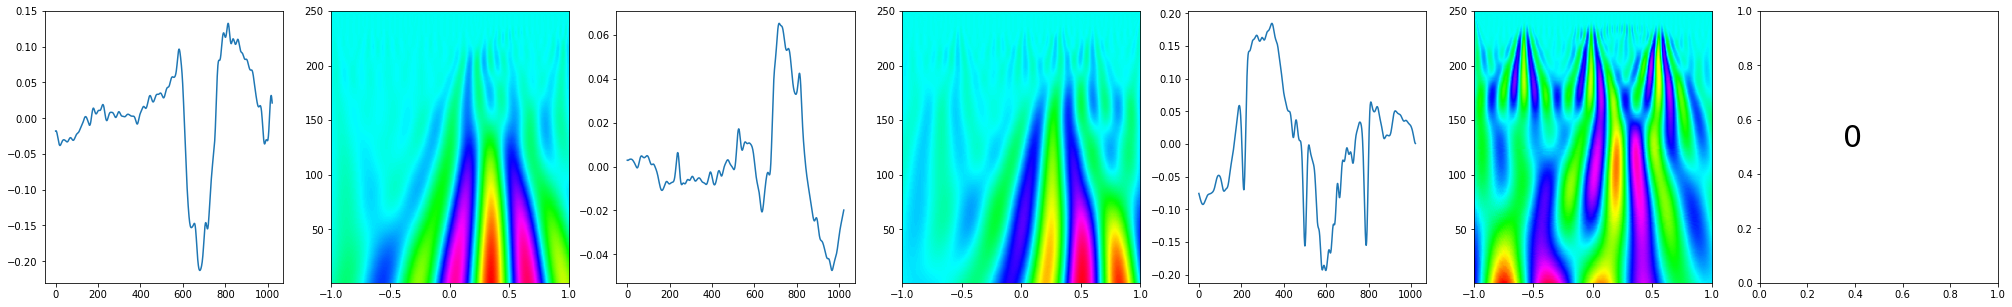

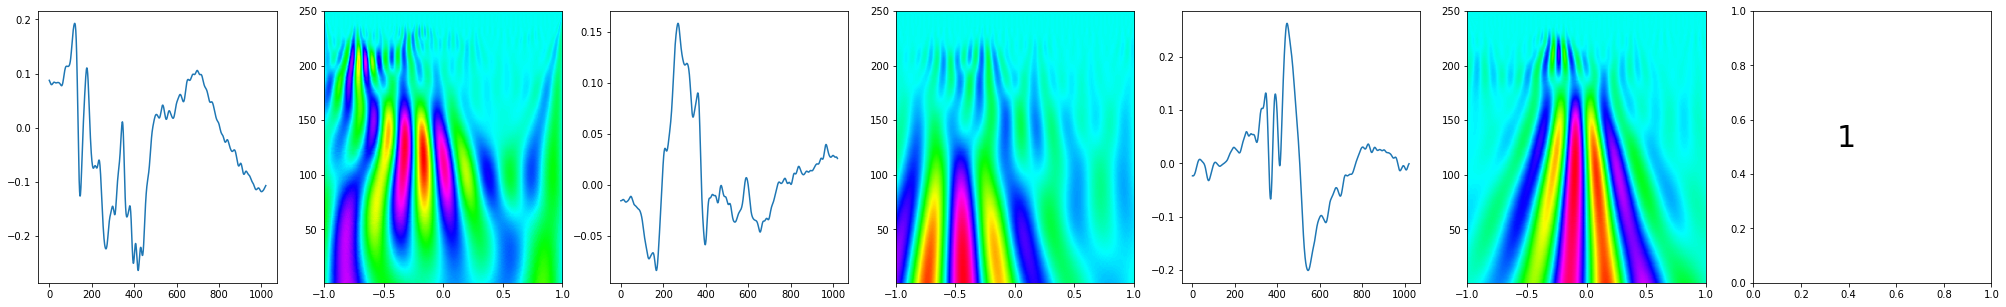

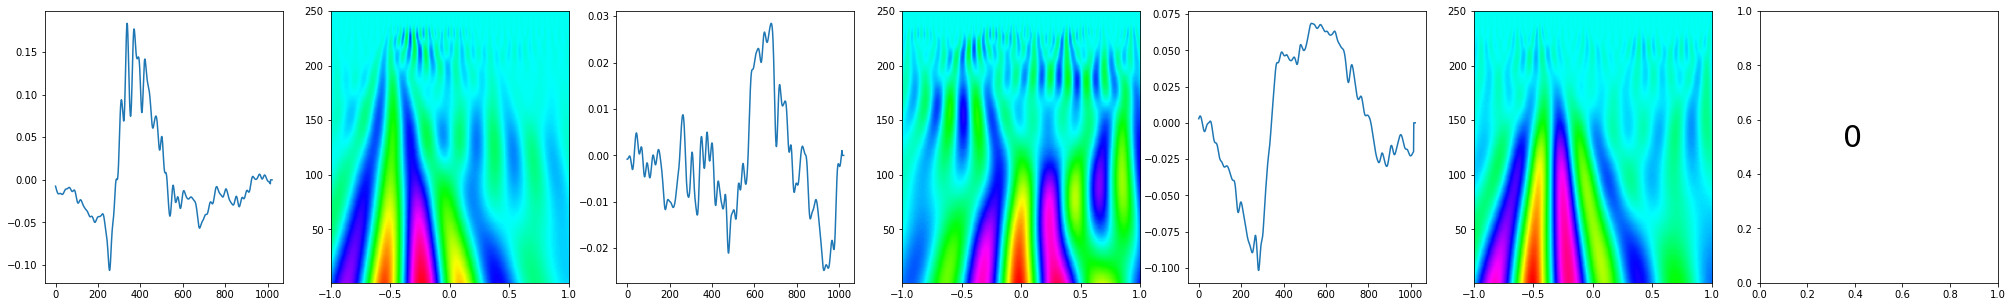

In [14]:
for i in [21,22,23]:
    create_plots(i,'hsv')

# Generate CWT transformations 

In [15]:
import pywt 

train_size = X_train.shape[0]
test_size= X_test.shape[0]


train_data_cwt = np.ndarray(shape=(train_size, rng, rng, 3))

for i in range(0,train_size):
    for j in range(0,3):
        signal = X_train[i, :, j]
        coeff, freq = pywt.cwt(signal, scales, waveletname, 1)
        coeff_ = coeff[:,:rng]
        train_data_cwt[i, :, :, j] = coeff_

test_data_cwt = np.ndarray(shape=(test_size, rng, rng, 3))

for i in range(0,test_size):
    for j in range(0,3):
        signal = X_test[i, :, j]
        coeff, freq = pywt.cwt(signal, scales, waveletname, 1)
        coeff_ = coeff[:,:rng]
        test_data_cwt[i, :, :, j] = coeff_


X_train = train_data_cwt
X_test = test_data_cwt

np.save('X_train', X_train)
np.save('X_test', X_test)

In [16]:
# After CWT transformations 

X_test = np.load('X_test.npy')
X_train = np.load('X_train.npy')

In [17]:
X_train.shape

(412, 250, 250, 3)

In [18]:
y_train.shape

(412,)

In [19]:
X_test.shape

(46, 250, 250, 3)

In [20]:
y_test.shape

(46,)

# Model with CNN 

In [23]:
import keras
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.callbacks import History 
history = History()

img_x = X_train.shape[1]
img_y = X_train.shape[1]
img_z = X_train.shape[-1]
input_shape = (img_x, img_y, img_z)

batch_size = 16
epochs = 25

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')


model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(output, activation='sigmoid'))

model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam(lr = 0.0001),
              metrics=['accuracy'])


model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, y_test),
          callbacks=[history])

train_score = model.evaluate(X_train, y_train, verbose=0)
print('Train loss: {}, Train accuracy: {}'.format(train_score[0], train_score[1]))
test_score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss: {}, Test accuracy: {}'.format(test_score[0], test_score[1]))

Train on 412 samples, validate on 46 samples
Epoch 1/25
412/412 [==============================] - 7s 17ms/step - loss: 0.7234 - acc: 0.5874 - val_loss: 0.5889 - val_acc: 0.6522
Epoch 2/25
412/412 [==============================] - 3s 6ms/step - loss: 0.6346 - acc: 0.6893 - val_loss: 0.5664 - val_acc: 0.6957
Epoch 3/25
412/412 [==============================] - 2s 6ms/step - loss: 0.5815 - acc: 0.7451 - val_loss: 0.5739 - val_acc: 0.6087
Epoch 4/25
412/412 [==============================] - 2s 6ms/step - loss: 0.5618 - acc: 0.7476 - val_loss: 0.5441 - val_acc: 0.7391
Epoch 5/25
412/412 [==============================] - 2s 6ms/step - loss: 0.4966 - acc: 0.7791 - val_loss: 0.5745 - val_acc: 0.6957
Epoch 6/25
412/412 [==============================] - 2s 6ms/step - loss: 0.4318 - acc: 0.8277 - val_loss: 0.6640 - val_acc: 0.6739
Epoch 7/25
412/412 [==============================] - 2s 6ms/step - loss: 0.4226 - acc: 0.8495 - val_loss: 0.6597 - val_acc: 0.5870
Epoch 8/25
412/412 [==========

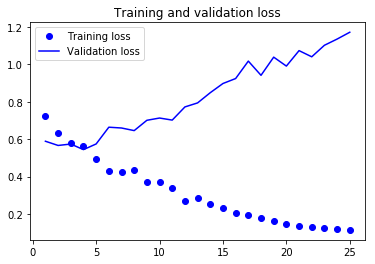

In [24]:
### Plot Losss
def plot_loss():
    acc = history.history['acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

plot_loss()

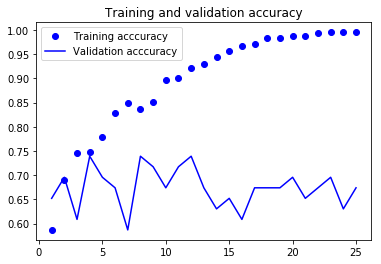

In [25]:
### Plot accuracy 

def plot_accuracy():
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    epochs = range(1, len(acc) + 1)
    plt.figure()
    plt.plot(epochs, acc, 'bo', label='Training acccuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation acccuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.show()
    
plot_accuracy()

In [27]:
from sklearn.metrics import classification_report
import numpy as np

if len(set(y_train)) >  2:
    y_test = np.argmax(y_test, axis=1) # Convert one-hot to index
y_pred = model.predict_classes(X_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.64      0.67      0.65        21
          1       0.71      0.68      0.69        25

avg / total       0.68      0.67      0.67        46



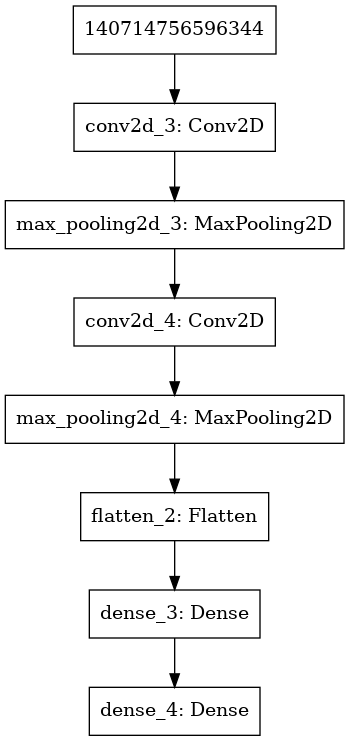

In [28]:
import pydot
from IPython.display import Image
from keras.utils import plot_model
plot_model(model, to_file='lstm.png')
Image(filename='lstm.png') 